---
# Create CAM7 topography file for CESM3 pli
- Author: Jiang Zhu (jiangzhu@ucar.edu)
- Tools used
  - [NCAR_Topo](https://github.com/NCAR/Topo) by Peter Lauritzen
  - [UXarray](https://uxarray.readthedocs.io/en/latest/) (only used for visualization)
- Notes: I ran the notebook on Casper and used 100 GB memory.
---

In [1]:
import subprocess
import re
import os
from datetime import date

import hvplot.xarray
import xarray as xr
import uxarray as ux
import numpy as np
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import xesmf

---
## Input: raw boundary condition data
### PlioMIP3 data in 1deg resolution 

In [2]:
plio_dir = '/glade/campaign/cesm/development/palwg/raw_boundary_data/pliomip3'

plio_fnames = [
    f'{plio_dir}/LP_exp_data/LP_topo_v1.0.nc',
    f'{plio_dir}/LP_exp_data/LP_LSM_v1.0.nc',
]

prei_fnames = [
    f'{plio_dir}/Modern_std_exp_data/Modern_std_topo_v1.0.nc',
    f'{plio_dir}/Modern_std_exp_data/Modern_std_LSM_v1.0.nc',
]

print(*(plio_fnames + prei_fnames), sep="\n")

/glade/campaign/cesm/development/palwg/raw_boundary_data/pliomip3/LP_exp_data/LP_topo_v1.0.nc
/glade/campaign/cesm/development/palwg/raw_boundary_data/pliomip3/LP_exp_data/LP_LSM_v1.0.nc
/glade/campaign/cesm/development/palwg/raw_boundary_data/pliomip3/Modern_std_exp_data/Modern_std_topo_v1.0.nc
/glade/campaign/cesm/development/palwg/raw_boundary_data/pliomip3/Modern_std_exp_data/Modern_std_LSM_v1.0.nc


### Preindustrial topo in 30" resolution

In [3]:
gmted_dir = '/glade/campaign/cesm/development/palwg/raw_boundary_data/gmted2010'
gmted_fname = 'gmted2010_modis_bedmachine-rawdata-220518.nc'

gmted = f"{gmted_dir}/{gmted_fname}"

print(gmted)

/glade/campaign/cesm/development/palwg/raw_boundary_data/gmted2010/gmted2010_modis_bedmachine-rawdata-220518.nc


---
## Grid configurations: Target grid SCRIP files,  smoothing scales, etc

In [4]:
greenlndantarcsgh30_fac = 2.5
source_data_identifier = 'pliomip3_lp'

target_grids = {
    'ne30pg3': {
        'smoothing_scale': 100,
        'scrip_file': '/glade/campaign/cesm/cesmdata/inputdata/share/scripgrids/ne30pg3_scrip_170417.nc',
        'scrip_file_gll': '/glade/campaign/cesm/cesmdata/inputdata/share/scripgrids/ne30np4_091226_pentagons.nc',
        'topo_pre': '/glade/campaign/cgd/amp/pel/topo/cesm3/ne30pg3_gmted2010_modis_bedmachine_nc3000_Laplace0100_noleak_greenlndantarcsgh30fac2.50_20250814.nc',
    },
    'ne16pg3': {
        'smoothing_scale': 200,
        'scrip_file': '/glade/campaign/cesm/cesmdata/inputdata/share/scripgrids/ne16pg3_scrip_170429.nc',
        'scrip_file_gll': '/glade/campaign/cesm/cesmdata/inputdata/share/scripgrids/ne16np4_scrip_171002.nc',
        'topo_pre': '/glade/campaign/cgd/ppc/jiangzhu/setup_data/cam_topo/pi/ne16pg3_gmted2010_modis_bedmachine_nc3000_Laplace0200_noleak_greenlndantarcsgh30fac2.50_20250817.nc',
    },
    'fv0.9x1.25': {
        'smoothing_scale': 100,
        'scrip_file': '/glade/campaign/cesm/cesmdata/inputdata/share/scripgrids/fv0.9x1.25_141008.nc',
        'topo_pre': '/glade/campaign/cgd/ppc/jiangzhu/setup_data/cam_topo/pi/fv0.9x1.25_gmted2010_modis_bedmachine_nc3000_Laplace0100_noleak_greenlndantarcsgh30fac2.50_20250817.nc',
    },
    'fv1.9x2.5': {
        'smoothing_scale': 200,
        'scrip_file': '/glade/campaign/cesm/cesmdata/inputdata/share/scripgrids/fv1.9x2.5_141008.nc',
        'topo_pre': '/glade/campaign/cgd/ppc/jiangzhu/setup_data/cam_topo/pi/fv1.9x2.5_gmted2010_modis_bedmachine_nc3000_Laplace0200_noleak_greenlndantarcsgh30fac2.50_20250818.nc',
    }
}

## Select grids to create cam topo files

In [44]:
selected_grids = ['fv1.9x2.5']

target_grids = {k: v for k, v in target_grids.items() if k in selected_grids}

target_grids

{'fv1.9x2.5': {'smoothing_scale': 200,
  'scrip_file': '/glade/campaign/cesm/cesmdata/inputdata/share/scripgrids/fv1.9x2.5_141008.nc',
  'topo_pre': '/glade/campaign/cgd/ppc/jiangzhu/setup_data/cam_topo/pi/fv1.9x2.5_gmted2010_modis_bedmachine_nc3000_Laplace0200_noleak_greenlndantarcsgh30fac2.50_20250818.nc',
  'topo_plio': '/glade/derecho/scratch/jiangzhu/setup_data/pliomip3/fv1.9x2.5_pliomip3_lp_nc3000_Laplace0200_noleak_greenlndantarcsgh30fac2.50_20250920.nc'}}

---
## Output

In [6]:
today = date.today().strftime("%Y%m%d")
print(today)

work_dir = '/glade/derecho/scratch/jiangzhu/setup_data/pliomip3'
subprocess.run(f"mkdir -p {work_dir}", shell=True)

20250920


CompletedProcess(args='mkdir -p /glade/derecho/scratch/jiangzhu/setup_data/pliomip3', returncode=0)

---
### Intermediate output files

In [8]:
gmted_plio_fname = f"gmted2010_modis_bedmachine-rawdata-220518_{source_data_identifier}_{today}.nc"
gmted_plio = f"{work_dir}/{gmted_plio_fname}"

ncube3000_plio_fname = f"gmted2010_modis_bedmachine-rawdata-220518_{source_data_identifier}_ncube3000_{today}.nc"
ncube3000_plio = f"{work_dir}/{ncube3000_plio_fname}"

print(gmted_plio)
print(ncube3000_plio)

/glade/derecho/scratch/jiangzhu/setup_data/pliomip3/gmted2010_modis_bedmachine-rawdata-220518_pliomip3_lp_20250920.nc
/glade/derecho/scratch/jiangzhu/setup_data/pliomip3/gmted2010_modis_bedmachine-rawdata-220518_pliomip3_lp_ncube3000_20250920.nc


---
## Tools used: NCAR Topo
- Create soft links of executables in the work directory.

In [9]:
ncar_topo_dir = '/glade/campaign/cesm/development/palwg/scripts/setup/ncar_topo'

src_bin_to_cube = f"{ncar_topo_dir}/bin_to_cube/bin_to_cube_casper"
src_cube_to_target = f"{ncar_topo_dir}/cube_to_target/cube_to_target_casper"

subprocess.run(
    ["ln", "-sfn", src_bin_to_cube, f"{work_dir}/bin_to_cube"],
    check=True)

subprocess.run(
    ["ln", "-sfn", src_cube_to_target, f"{work_dir}/cube_to_target"],
    check=True)

CompletedProcess(args=['ln', '-sfn', '/glade/campaign/cesm/development/palwg/scripts/setup/ncar_topo/cube_to_target/cube_to_target_casper', '/glade/derecho/scratch/jiangzhu/setup_data/pliomip3/cube_to_target'], returncode=0)

---
## Step 1: compute Late Pliocene topo by adding PlioMIP3 anomaly to modern gmted
- Input: PlioMIP3 topo files
- Input: `gmted`, modern-day hires topography file in 30' resolution
- Output: `gmted_plio`, Late Pliocene hires topography file in 30' resolution

### Read preindustrial & Late Pliocene topo from PlioMIP3

In [10]:
ds_plio = xr.open_mfdataset(plio_fnames)
ds_plio = ds_plio.rename({'p4_topo': 'topo', 'p4_lsm': 'lsm'})
ds_plio

<xarray.Dataset> Size: 521kB
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    topo     (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    lsm      (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
Attributes:
    Email:                 J.C.Tindall@leeds.ac.uk
    Information:           This is the PRISM4 Pliocene topography as presente...
    Institution:           University of Leeds
    Netcdf_Creation_Date:  2023-08-22
    Netcdf_author:         Tindall, J. C.
    Conventions:           CF-1.7

In [11]:
ds_prei = xr.open_mfdataset(prei_fnames)
ds_prei = ds_prei.rename({'etopo1_topo': 'topo', 'etopo1_lsm': 'lsm'})
ds_prei

<xarray.Dataset> Size: 521kB
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    topo     (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    lsm      (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
Attributes:
    Email:                 J.C.Tindall@leeds.ac.uk
    Information:           Etopo1 Data originally downloaded from www.ngdc.no...
    Institution:           University of Leeds
    Netcdf_Creation_Date:  2023-08-08
    Netcdf_author:         Tindall, J. C.
    Conventions:           CF-1.7

### Do not change topography over ocean

In [12]:
dsa = ds_plio - ds_prei

dsa['topo'] = xr.where(
    (ds_plio.lsm > 0) | (ds_prei.lsm > 0), dsa.topo, 0)

print(f"Maximum landfrac increase: {dsa.lsm.max().values}")
print(f"Maximum landfrac decrease: {dsa.lsm.min().values}")
print(f"Maximum elevation increase (m): {dsa.topo.max().values}")
print(f"Maximum elevation decrease (m): {dsa.topo.min().values}")

Maximum landfrac increase: 1.0
Maximum landfrac decrease: -1.0
Maximum elevation increase (m): 1361.0
Maximum elevation decrease (m): -3387.0


### Make plots

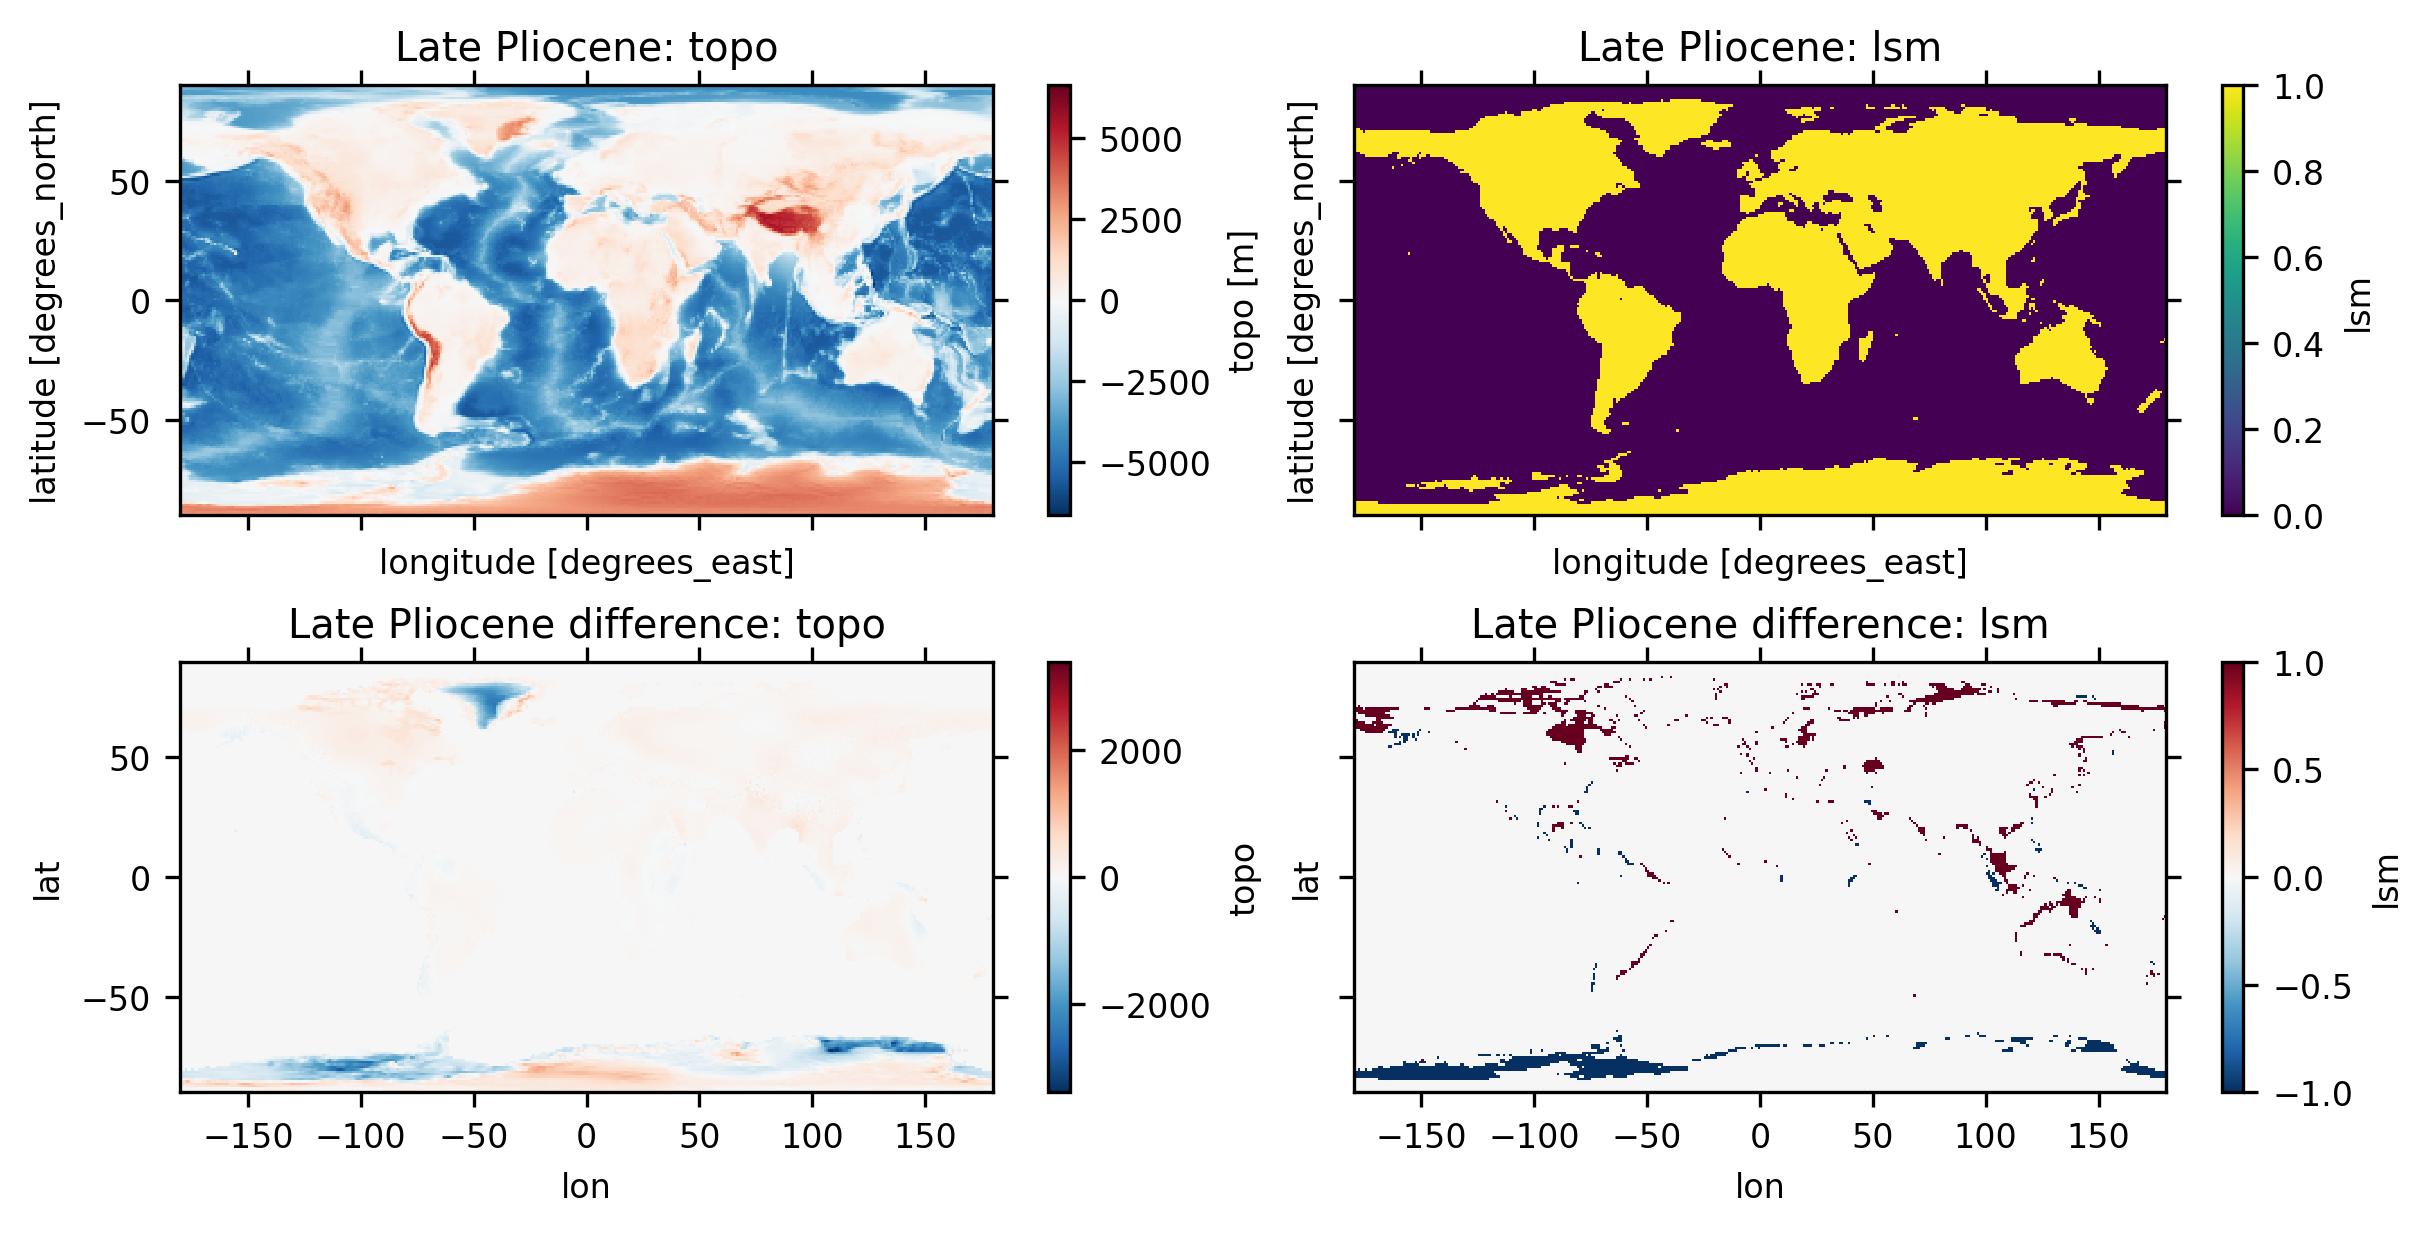

In [13]:

fig, axes = plt.subplots(2, 2, figsize=(8, 4),
                         sharex=True, sharey=True,
                         constrained_layout=True)

for vname, ax in zip(['topo', 'lsm'], axes[0, :]):
    ds_plio[vname].plot.pcolormesh(ax=ax)
    ax.set_title(f"Late Pliocene: {vname}")

for vname, ax in zip(['topo', 'lsm'], axes[1, :]):
    dsa[vname].plot.pcolormesh(ax=ax)
    ax.set_title(f"Late Pliocene difference: {vname}")

In [14]:
dsa.topo.hvplot(
    x='lon', y='lat', width=600, height=400, cmap='RdBu_r', clim=(-3000, 3000))

:Image   [lon,lat]   (topo)

### Read preindustrial topo in high res.
- NOTE: landfract is a binary land-sea mask containing 0 and 1

In [16]:
gmted_ds = xr.open_dataset(gmted, chunks='auto')
gmted_ds_new = gmted_ds.copy(deep=True)

gmted_ds

<xarray.Dataset> Size: 7GB
Dimensions:    (lat: 21600, lon: 43200)
Coordinates:
  * lon        (lon) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat        (lat) float64 173kB -90.0 -89.99 -89.98 ... 89.98 89.99 90.0
Data variables:
    landfract  (lat, lon) float32 4GB dask.array<chunksize=(4096, 8192), meta=np.ndarray>
    htopo      (lat, lon) float32 4GB dask.array<chunksize=(4096, 8192), meta=np.ndarray>
Attributes:
    CDI:            Climate Data Interface version 2.0.2 (https://mpimet.mpg....
    Conventions:    CF-1.6
    creation_data:  Wed May 18 09:18:44 MDT 2022
    history:        Wed May 18 09:29:23 2022: cdo merge gmted_bedmachine_stit...
    CDO:            Climate Data Operators version 2.0.1 (https://mpimet.mpg....

### Compute topo and land fraction anomalies & add them to the PI hires variables
- Note: we wrap the variables in longitude and pad in latitude to deal with extrapolation
- Note: Using `method="nearest"` in `interp` is prefered, as it better preserves the PI hires info

In [17]:
def wrap_pad_latlon(ds, lon_name="lon", lat_name="lat"):
    """
    Wrap longitude and pad latitude if ds does not already
    cover [-180, 180] in lon and [-90, 90] in lat.
    """
    out = ds.copy()
    lon = out[lon_name].values
    lat = out[lat_name].values

    # ---- Wrap longitude separately ----
    if lon.min() > -180:
        west_pad = out.isel({lon_name: -1}).copy()
        west_pad = west_pad.assign_coords({lon_name: np.array([lon[-1] - 360])})
        out = xr.concat([west_pad, out], dim=lon_name)

    if lon.max() < 180:
        east_pad = out.isel({lon_name: 0}).copy()
        east_pad = east_pad.assign_coords({lon_name: np.array([lon[0] + 360])})
        out = xr.concat([out, east_pad], dim=lon_name)

    # ---- Pad latitude ----
    if lat.min() > -90:
        south_pad = out.isel({lat_name: 0}).expand_dims({lat_name: [-90]})
        out = xr.concat([south_pad, out], dim=lat_name)

    if lat.max() < 90:
        north_pad = out.isel({lat_name: -1}).expand_dims({lat_name: [90]})
        out = xr.concat([out, north_pad], dim=lat_name)

    return out

In [18]:
%%time

dsa_wrap_pad = wrap_pad_latlon(dsa)

lndf_ano_interp = dsa_wrap_pad.lsm.interp(
    lat=gmted_ds.lat, lon=gmted_ds.lon, method="nearest",
)

topo_ano_interp = dsa_wrap_pad.topo.interp(
    lat=gmted_ds.lat, lon=gmted_ds.lon, method="nearest",
)

dsa_wrap_pad

CPU times: user 27.8 ms, sys: 0 ns, total: 27.8 ms
Wall time: 27.8 ms


<xarray.Dataset> Size: 531kB
Dimensions:  (lat: 182, lon: 362)
Coordinates:
  * lat      (lat) float64 1kB -90.0 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5 90.0
  * lon      (lon) float64 3kB -180.5 -179.5 -178.5 -177.5 ... 178.5 179.5 180.5
Data variables:
    topo     (lat, lon) float32 264kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    lsm      (lat, lon) float32 264kB dask.array<chunksize=(1, 1), meta=np.ndarray>

In [19]:
%%time

# Apply landfract anomaly, then clip data into 0 and 1
gmted_ds_new['landfract'] = (gmted_ds['landfract'] + lndf_ano_interp).clip(min=0, max=1)

# Apply topography anomaly
htopo_new = gmted_ds['htopo'] + topo_ano_interp

# Topo modification 1: new ocean cells shouldn't be too high or too low
# Topo modification 2: new land cells (mostly over coatal regions) shouldn't be submerged
# Topo modification 3: Don't decrease topo too much
cond1 = lndf_ano_interp == -1
cond2 = (lndf_ano_interp == 1) & (htopo_new < 0)
cond3 = (topo_ano_interp < 0) & (htopo_new < 0)
gmted_ds_new['htopo'] = xr.where(cond1 | cond2 | cond3, 0, htopo_new)

print(np.unique(gmted_ds_new['landfract'].values))

print(f"Maximum elevation in PI (m): {gmted_ds.htopo.max().values}")
print(f"Minimum elevation in PI (m): {gmted_ds.htopo.min().values}")

print(f"Maximum elevation in Late Pliocene (m): {gmted_ds_new.htopo.max().values}")
print(f"Minimum elevation in Late Pliocene (m): {gmted_ds_new.htopo.min().values}")

print(f"Maximum elevation increase (m): {(gmted_ds_new-gmted_ds).htopo.max().values}")
print(f"Maximum elevation decrease (m): {(gmted_ds_new-gmted_ds).htopo.min().values}")

# Save netcdf file
if os.path.exists(gmted_plio):
    os.remove(gmted_plio)

gmted_ds_new.to_netcdf(gmted_plio, mode="w", compute=True)

[0. 1.]
Maximum elevation in PI (m): 8625.0
Minimum elevation in PI (m): -430.0
Maximum elevation in Late Pliocene (m): 8757.0
Minimum elevation in Late Pliocene (m): -430.0
Maximum elevation increase (m): 1361.0001220703125
Maximum elevation decrease (m): -3723.35302734375
CPU times: user 3min 3s, sys: 6min 34s, total: 9min 38s
Wall time: 10min 30s


### Plot to check results

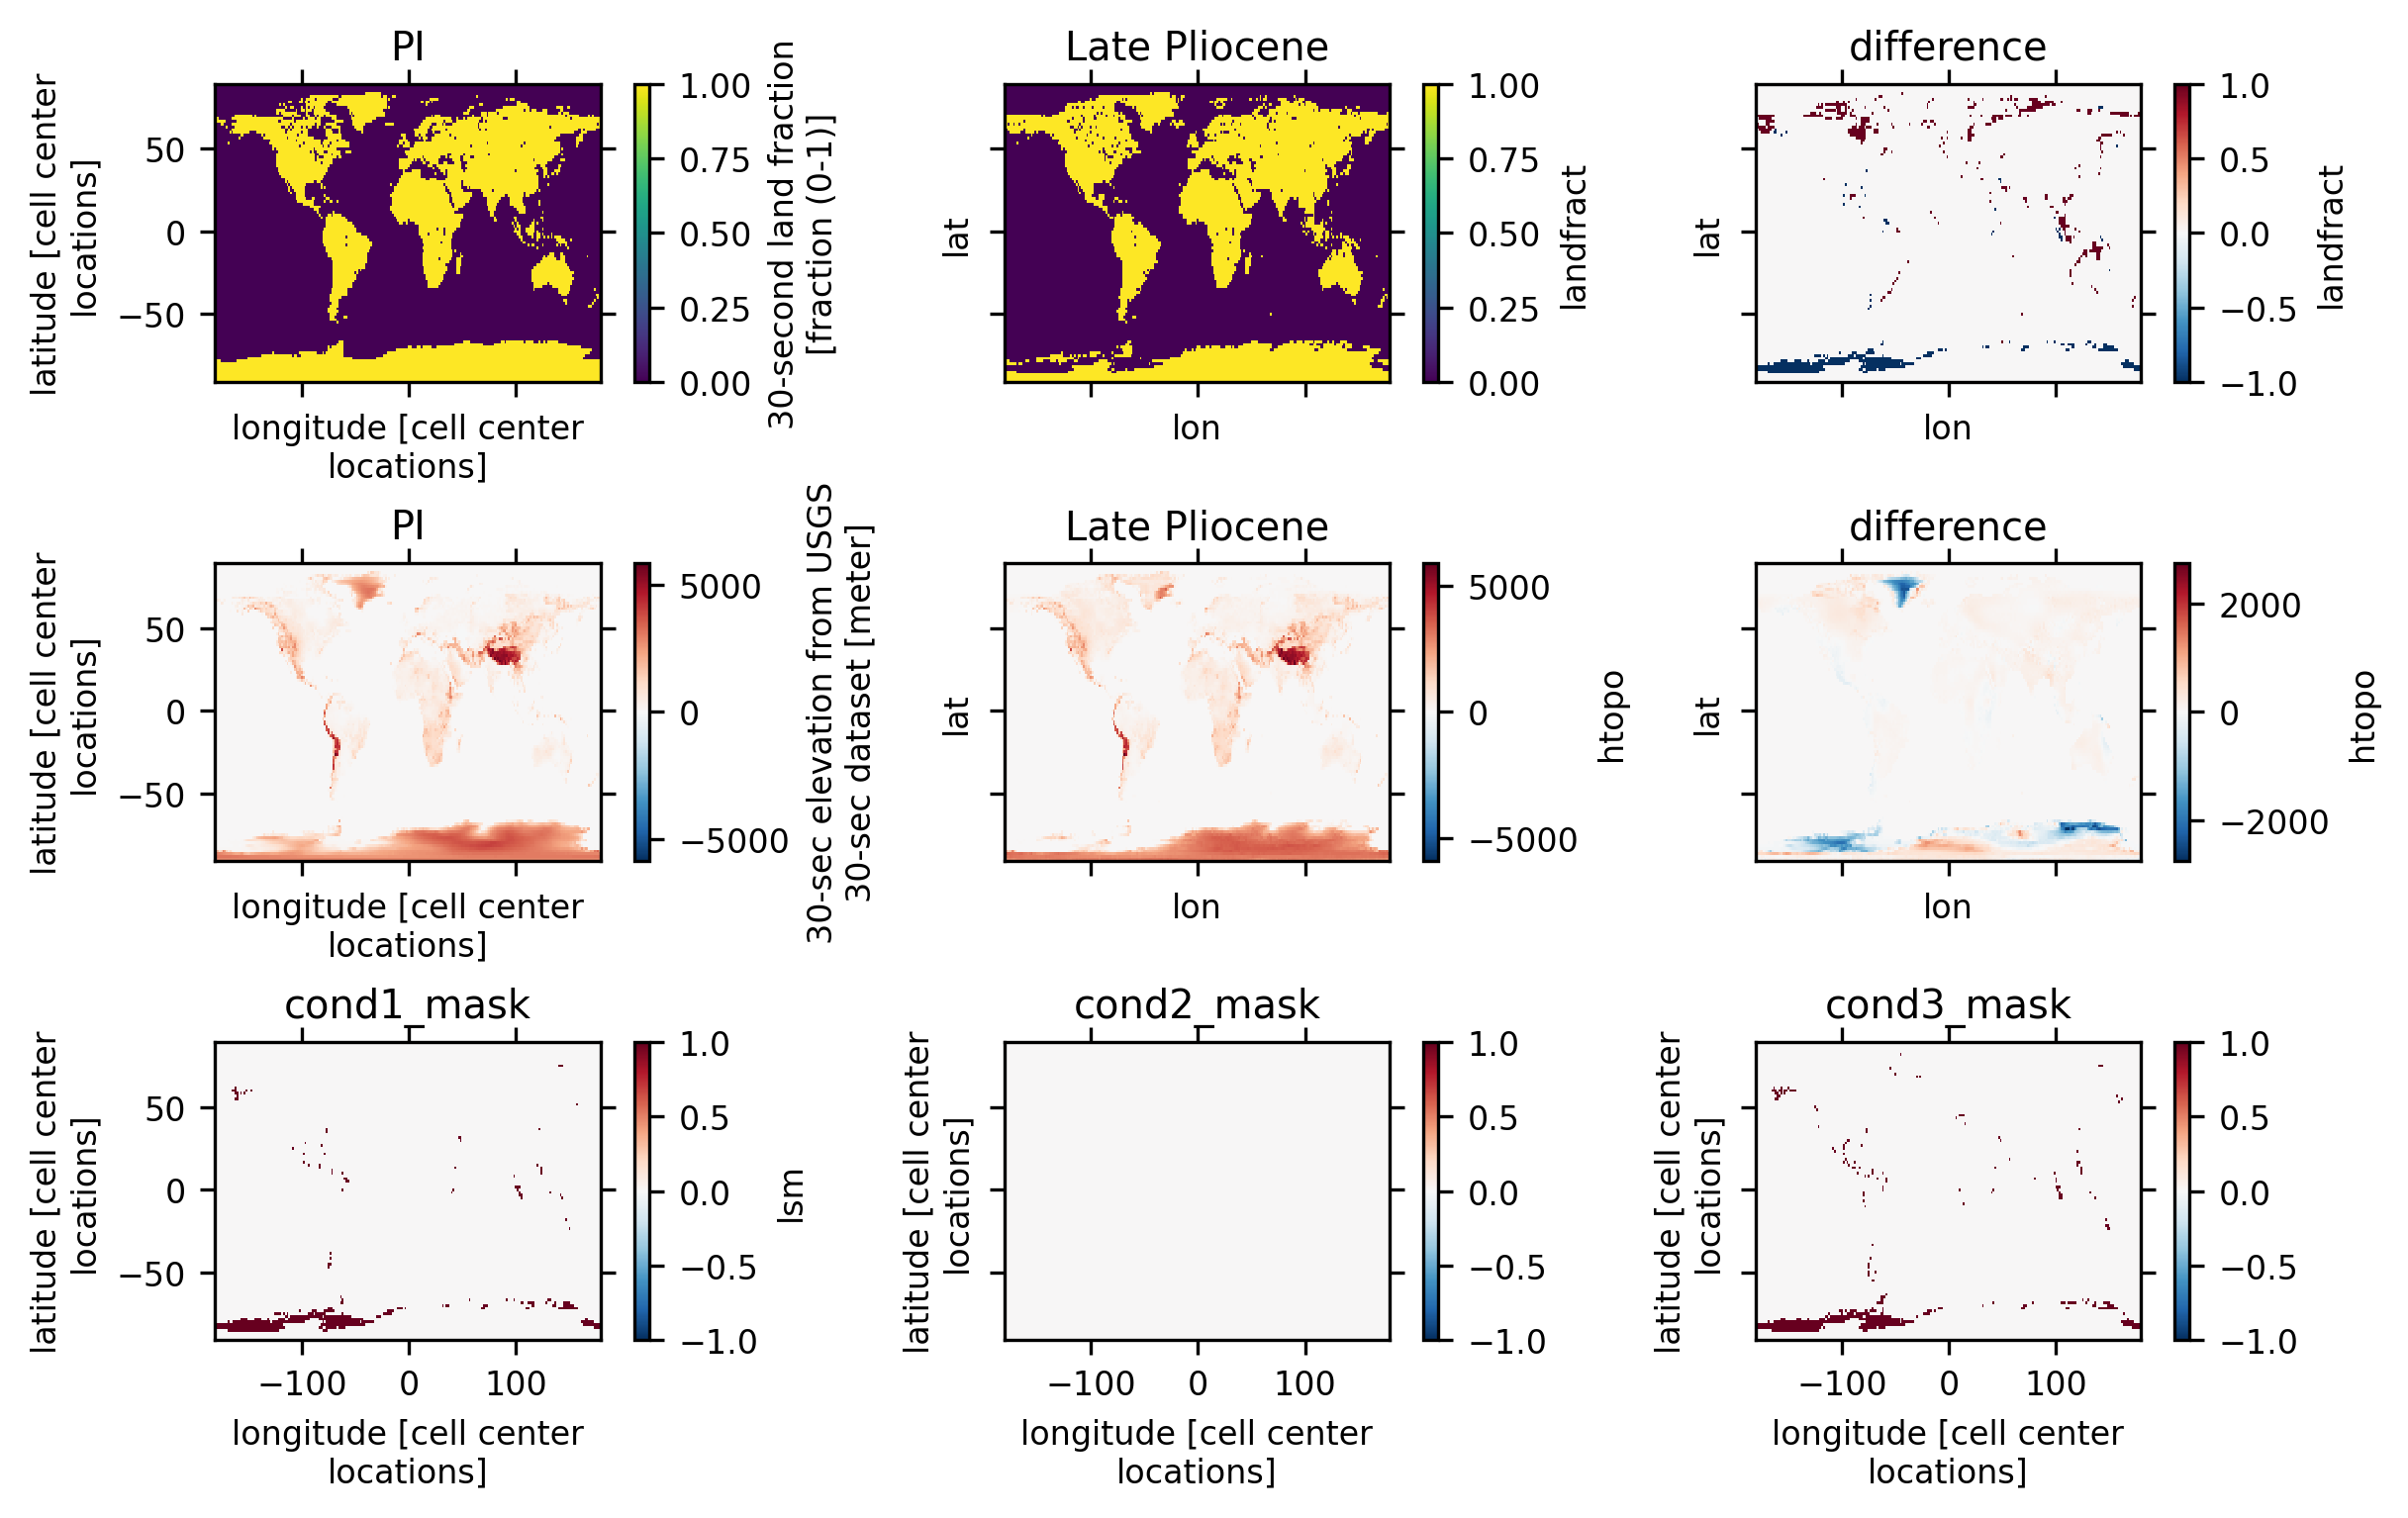

In [20]:
fig, axes = plt.subplots(3, 3, figsize=(8, 5),
                         sharex=True, sharey=True,
                         constrained_layout=True)

# Coarsen datasets for quick plotting
thin = 200
prei = gmted_ds.isel(
    lat=slice(None, None, thin), lon=slice(None, None, thin)).compute()
plio = gmted_ds_new.isel(
    lat=slice(None, None, thin), lon=slice(None, None, thin)).compute()
diff = plio - prei

ds_list = [prei, plio, diff]
titles = ['PI', 'Late Pliocene', 'difference']

# Top row: landfrac
for ds, ax, title in zip(ds_list, axes[0, :], titles):
    ds.landfract.plot.pcolormesh(ax=ax)
    ax.set_title(title)

# Middle row: htopo
for ds, ax, title in zip(ds_list, axes[1, :], titles):
    ds.htopo.plot.pcolormesh(ax=ax)
    ax.set_title(title)

# Bottom row: masks indicating where topo could be clipped to zero
for mask, ax, title in zip(
    [cond1, cond2, cond3],
    axes[2, :],
    ['cond1_mask', 'cond2_mask', 'cond3_mask']):
    mask.thin(200).plot.pcolormesh(ax=ax, vmin=-1, vmax=1, cmap='RdBu_r')
    ax.set_title(title)

In [21]:
p1 = plio.htopo.hvplot(
    x='lon', y='lat', width=600, height=400, cmap='RdBu_r', clim=(-2000, 2000))

p2 = plio.landfract.hvplot(
    x='lon', y='lat', width=600, height=400, cmap='RdBu_r')

p3 = diff.htopo.hvplot(
    x='lon', y='lat', width=600, height=400, cmap='RdBu_r')

p4 = diff.landfract.hvplot(
    x='lon', y='lat', width=600, height=400, cmap='RdBu_r')

p1 + p2 + p3 + p4

:Layout
   .Image.I   :Image   [lon,lat]   (htopo)
   .Image.II  :Image   [lon,lat]   (landfract)
   .Image.III :Image   [lon,lat]   (htopo)
   .Image.IV  :Image   [lon,lat]   (landfract)

### Create a new landm_coslat for CAM4
- This is needed for running NCAR TOPO but it is only used for CAM4

/glade/campaign/cesm/development/palwg/scripts/setup/ncar_topo/bin_to_cube/landm_coslat.nc
/glade/derecho/scratch/jiangzhu/setup_data/pliomip3/landm_coslat.nc


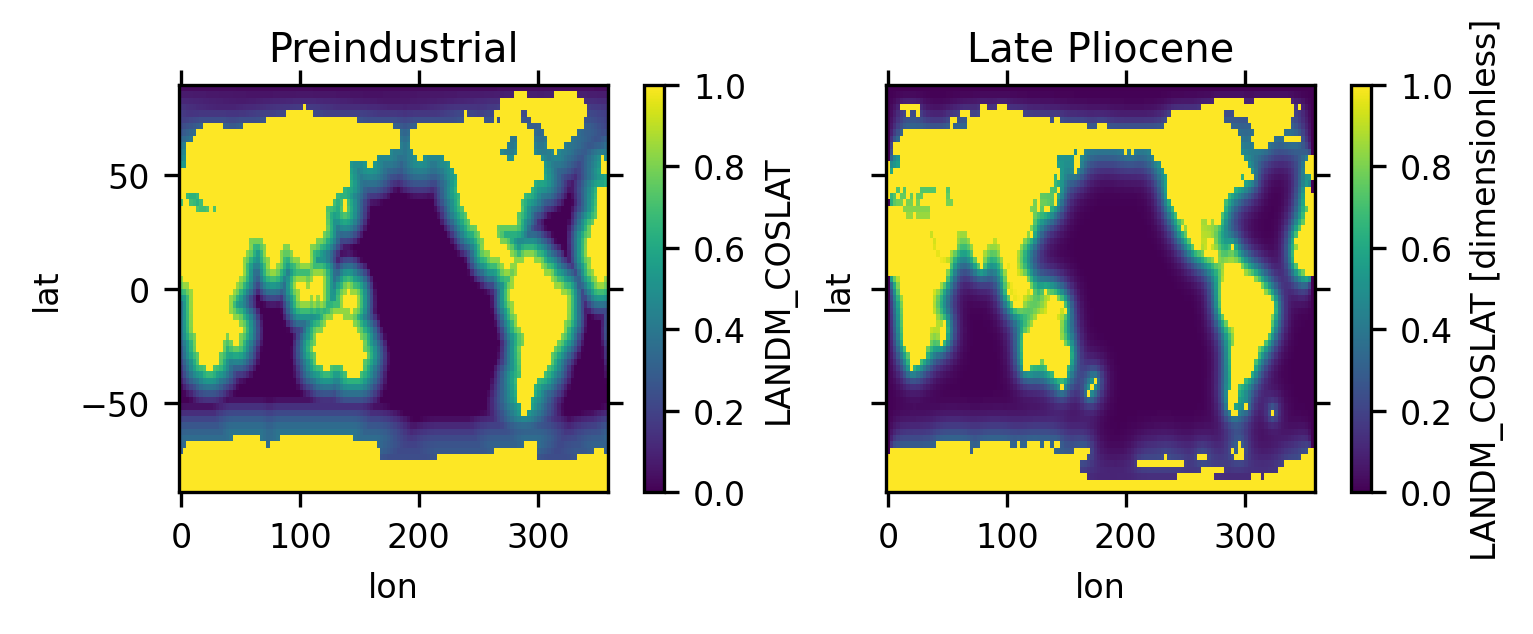

In [22]:
landm_coslat_prei = f"{ncar_topo_dir}/bin_to_cube/landm_coslat.nc"
landm_coslat_plio = f"{work_dir}/landm_coslat.nc"
print(landm_coslat_prei)
print(landm_coslat_plio)

ds_landm_prei = xr.open_dataset(landm_coslat_prei)
ds_landm_plio = ds_landm_prei.copy()

regridder = xesmf.Regridder(
    ds_plio, ds_landm_prei, 'nearest_s2d', periodic=True)
lsm_regridded = regridder(ds_plio.lsm)

# Iterative smoothing - only smooth partial land/ocean areas
for i in range(20):
    smoothed = mpcalc.smooth_n_point(lsm_regridded, 9)
    lsm_regridded = xr.where(lsm_regridded < 1, smoothed, lsm_regridded)

# Apply cosine latitude weighting, preserve pure land points
coslat = np.cos(np.radians(ds_landm_plio.lat))
ds_landm_plio['LANDM_COSLAT'] = xr.where(
    lsm_regridded >= 1, lsm_regridded, lsm_regridded * coslat).compute()

fig, axes = plt.subplots(1, 2, figsize=(5, 2),
                         sharex=True, sharey=True,
                         constrained_layout=True)
ds_landm_prei.LANDM_COSLAT.plot(ax=axes[0])
axes[0].set_title('Preindustrial')
ds_landm_plio.LANDM_COSLAT.plot(ax=axes[1])
axes[1].set_title('Late Pliocene')

# Save netcdf file
if os.path.exists(landm_coslat_plio):
    os.remove(landm_coslat_plio)

ds_landm_plio[['LANDM_COSLAT']].to_netcdf(landm_coslat_plio)

---
# Step 2: run NCAR Topo: bin_to_cube
- Input: `gmted_plio`
- Output: `ncube3000_plio`
- [Users' Guide](https://github.com/NCAR/Topo/wiki/User's-Guide)
- Note: we first create the namelist file and then use `qcmd` to run `bin_to_cube`

In [23]:
%%time

# Write namelist file first
with open(f"{work_dir}/bin_to_cube.nl", "w") as f:
    f.write(f"""&binparams
raw_latlon_data_file = '{gmted_plio}'
output_file          = '{ncube3000_plio}'
ncube                = 3000
/""")


# Run bin_to_cube with qcmd
cmd = f"""cd {work_dir}; \
qcmd -l walltime=04:00:00 -A p93300324 -l select=1:ncpus=1:mem=200GB \
-- ./bin_to_cube"""

print(cmd)
subprocess.run(cmd, shell=True, check=True)

cd /glade/derecho/scratch/jiangzhu/setup_data/pliomip3; qcmd -l walltime=04:00:00 -A p93300324 -l select=1:ncpus=1:mem=200GB -- ./bin_to_cube
Waiting on job launch; 8909154.casper-pbs with qsub arguments:
    qsub  -l select=1:ncpus=1:mem=200GB -A p93300324 -q casper@casper-pbs -l walltime=04:00:00

Thus no job control in this shell.
Intermediate cubed-sphere resolution         3000
Opening:
/glade/derecho/scratch/jiangzhu/setup_data/pliomip3/gmted2010_modis_bedmachine-
rawdata-220518_pliomip3_lp_20250920.nc
lon-lat dimensions:        43200       21600
min/max of 30sec land fraction    0    1
read terrain data
read lon
read lat
close file
done reading data from netCDF file
compute volume for raw data
consistency of lat-lon area  2.147739763813661E-010
mean elevation (raw data)   241.667130757393
read LANDM_COSLAT from file
lon-lat dimensions:          128          64
min/max of landm_coslat  0.000000000000000E+000   1.00000000000000
read lon
read lat
close file
done reading in LANDM_CO

CompletedProcess(args='cd /glade/derecho/scratch/jiangzhu/setup_data/pliomip3; qcmd -l walltime=04:00:00 -A p93300324 -l select=1:ncpus=1:mem=200GB -- ./bin_to_cube', returncode=0)

---
## Step 3: run NCAR Topo: cube_to_target
- Input: `ncube3000_plio`
- Output: `topo_plio`
- We wrtie a shell script and use `qcmd` to run `cube_to_target`
- We loop over multiple target grids if needed

In [24]:
%%time

script_file = f"{work_dir}/create_pliomip3_lp_topo.csh"

with open(script_file, "w") as f:
    f.write('#!/bin/tcsh\n')
    for key, grid in target_grids.items():
        cmd = [
            f"{work_dir}/cube_to_target",
            f"--intermediate_cs_name {ncube3000_plio}",
            f"--output_data_directory {work_dir}",
            f"--source_data_identifier {source_data_identifier}",
            f"--output_grid {key}",
            f"--grid_descriptor_file {grid['scrip_file']}",
            f"--smoothing_scale {grid['smoothing_scale']}",
            f"--greenlndantarcsgh30_fac {greenlndantarcsgh30_fac}",
            "--jmax_segments 20000",
            "--name_email_of_creator 'Jiang Zhu, jiangzhu@ucar.edu'"
        ]
        
        if grid.get('scrip_file_gll'):
            cmd.append(f"--grid_descriptor_file_gll {grid['scrip_file_gll']}")
    
        f.write(" ".join(cmd) + "\n")

os.chmod(script_file, 0o755)

cmd = f"""qcmd -l walltime=06:00:00 \
  -A p93300324 \
  -l select=1:ncpus=1:mem=200GB \
  -- source {script_file}"""

print(cmd)
subprocess.run(cmd, shell=True, check=True)

qcmd -l walltime=06:00:00   -A p93300324   -l select=1:ncpus=1:mem=200GB   -- source /glade/derecho/scratch/jiangzhu/setup_data/pliomip3/create_pliomip3_lp_topo.csh
Waiting on job launch; 8909389.casper-pbs with qsub arguments:
    qsub  -l select=1:ncpus=1:mem=200GB -A p93300324 -q casper@casper-pbs -l walltime=06:00:00

Thus no job control in this shell.
No smoothed topo file specified

Namelist settings

smoothing_scale                 =    200.000000000000
nwindow_halfwidth               =            0
ncube_sph_smooth_fine           =            0
grid_descriptor_fname           =
/glade/campaign/cesm/cesmdata/inputdata/share/scripgrids/fv1.9x2.5_141008.nc
intermediate_cubed_sphere_fname =
/glade/derecho/scratch/jiangzhu/setup_data/pliomip3/gmted2010_modis_bedmachine-
rawdata-220518_pliomip3_lp_ncube3000_20250920.nc
output_grid                     = fv1.9x2.5
luse_prefilter                  =  F
lfind_ridges                    =  T
rrfac_max                       =            1
ld

CompletedProcess(args='qcmd -l walltime=06:00:00   -A p93300324   -l select=1:ncpus=1:mem=200GB   -- source /glade/derecho/scratch/jiangzhu/setup_data/pliomip3/create_pliomip3_lp_topo.csh', returncode=0)

## Step 4: Use UXarray or Xarray to examine the results

In [42]:
# You can add more variables to examine.
vinfo = {
    "PHIS": {"clim": (0, 30000), "clim_delta": (-10000, 10000)},
    "SGH30": {"clim": (0, 200), "clim_delta": (-50, 50)},
    "SGH": {"clim": (0, 500), "clim_delta": (-100, 100)},
    "ANISO": {"clim": (0, 1), "clim_delta": (-1, 1)},
    "MXDIS": {"clim": (0, 2000), "clim_delta": (-2000, 2000)},
}
vnames = list(vinfo.keys())


def maybe_isel(da, dim="nrdg", index=1):
    return da.isel({dim: index}) if dim in da.dims else da


# --- Loop over all grids ---
for grid_name, target_grid in target_grids.items():

    pre_file = target_grid["topo_pre"]
    pli_file = target_grid["topo_plio"]
    scrip_file = target_grid["scrip_file"]

    print(f"\n--- Plotting grid: {grid_name} ---")
    print(f"PI file: {pre_file}")
    print(f"pli file: {pli_file}")

    # Open datasets
    if re.search("fv", grid_name):
        ds_topo_pre = xr.open_dataset(pre_file)
        ds_topo_pli = xr.open_dataset(pli_file)
    else:
        ds_topo_pre = ux.open_dataset(scrip_file, pre_file)
        ds_topo_pli = ux.open_dataset(scrip_file, pli_file)

    # Loop over variables
    for vname in vnames:
        clim = vinfo[vname]["clim"]
        clim_delta = vinfo[vname]["clim_delta"]

        pre = maybe_isel(ds_topo_pre[vname])
        delta = maybe_isel(ds_topo_pli[vname] - ds_topo_pre[vname])

        # FV grid use hvplot
        if re.search("fv", grid_name):
            
            p1 = pre.hvplot(
                width=500, height=300, 
                clim=clim, cmap="terrain", title=f"PI {vname}")

            p2 = delta.hvplot(
                width=500, height=300,
                clim=clim_delta, cmap="RdBu_r", title=f"Δ (pli – PI) {vname}")
            display(p1 + p2)
        
        # SE grid use "plot"
        else:
            p1 = pre.plot(
                width=500, height=300,
                clim=clim, cmap="terrain", title=f"PI {vname}")
            p2 = delta.plot(
                width=500, height=300,
                clim=clim_delta, cmap="RdBu_r", title=f"Δ (pli – PI) {vname}")
            display(p1 + p2)


--- Plotting grid: fv1.9x2.5 ---
PI file: /glade/campaign/cgd/ppc/jiangzhu/setup_data/cam_topo/pi/fv1.9x2.5_gmted2010_modis_bedmachine_nc3000_Laplace0200_noleak_greenlndantarcsgh30fac2.50_20250818.nc
pli file: /glade/derecho/scratch/jiangzhu/setup_data/pliomip3/fv1.9x2.5_pliomip3_lp_nc3000_Laplace0200_noleak_greenlndantarcsgh30fac2.50_20250920.nc


:Layout
   .Image.I  :Image   [lon,lat]   (surface geopotential)
   .Image.II :Image   [lon,lat]   (PHIS)

:Layout
   .Image.I  :Image   [lon,lat]   (standard deviation of 30s elevation from 3km cube)
   .Image.II :Image   [lon,lat]   (SGH30)

:Layout
   .Image.I  :Image   [lon,lat]   (standard deviation of 3km cubed-sphere elevation)
   .Image.II :Image   [lon,lat]   (SGH)

:Layout
   .Image.I  :Image   [lon,lat]   (Variance fraction explained by ridge)
   .Image.II :Image   [lon,lat]   (ANISO)

:Layout
   .Image.I  :Image   [lon,lat]   (Obtsacle height diagnosed by ridge-finding alg. )
   .Image.II :Image   [lon,lat]   (MXDIS)